In [4]:
!pip install networkx


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: C:\Python312\python.exe -m pip install --upgrade pip


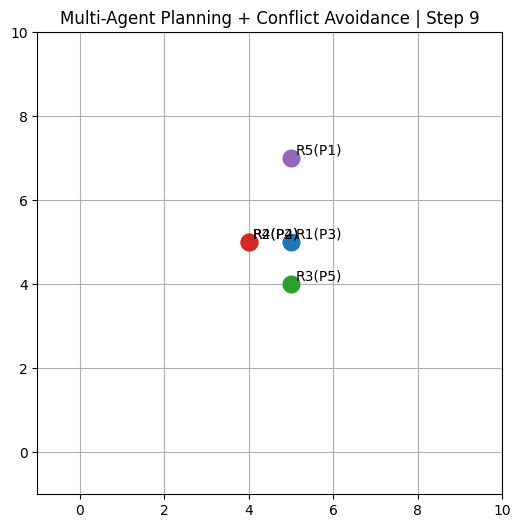


===== EVALUATION METRICS =====
Makespan (Total Time Steps): 10
Tasks Completed: 5
Task Throughput: 0.5
Conflict Events Avoided: 14
Idle Time per Robot: {'R1': 0, 'R2': 2, 'R3': 0, 'R4': 1, 'R5': 0}
Robot Utilization: {'R1': 1.0, 'R2': 0.8, 'R3': 1.0, 'R4': 0.9, 'R5': 1.0}
Dependency Violations: 0


In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

# -----------------------------
# TASK DAG
# -----------------------------
tasks = {
    "T1": {"name": "Transport Bricks", "goal": [4, 4]},
    "T2": {"name": "Transport Cement", "goal": [4, 5]},
    "T3": {"name": "Assembly", "goal": [6, 4]},
    "T4": {"name": "Electrical", "goal": [6, 5]},
    "T5": {"name": "Inspection", "goal": [5, 7]},
}

dependencies = [
    ("T1", "T3"),
    ("T2", "T3"),
    ("T3", "T4"),
    ("T4", "T5"),
]

G = nx.DiGraph()
G.add_nodes_from(tasks.keys())
G.add_edges_from(dependencies)

# -----------------------------
# ROBOTS (priority: higher wins)
# -----------------------------
robots = {
    "R1": {"pos": [0, 0], "priority": 3, "task": None},
    "R2": {"pos": [0, 9], "priority": 2, "task": None},
    "R3": {"pos": [9, 0], "priority": 5, "task": None},
    "R4": {"pos": [9, 9], "priority": 4, "task": None},
    "R5": {"pos": [5, 5], "priority": 1, "task": None},
}

# -----------------------------
# METRICS INITIALIZATION
# -----------------------------
completed_tasks = set()
conflicts = 0
idle_time = {r: 0 for r in robots}
active_time = {r: 0 for r in robots}
dependency_violations = 0

# -----------------------------
# HELPER FUNCTIONS
# -----------------------------
def available_tasks():
    avail = []
    for t in G.nodes():
        if t not in completed_tasks:
            preds = list(G.predecessors(t))
            if all(p in completed_tasks for p in preds):
                avail.append(t)
    return avail

def occupied_positions():
    return {tuple(r["pos"]): rid for rid, r in robots.items()}

def move_step(pos, goal):
    new = pos.copy()
    if pos[0] < goal[0]:
        new[0] += 1
    elif pos[0] > goal[0]:
        new[0] -= 1
    elif pos[1] < goal[1]:
        new[1] += 1
    elif pos[1] > goal[1]:
        new[1] -= 1
    return new

# -----------------------------
# SIMULATION LOOP
# -----------------------------
MAX_STEPS = 30

for step in range(MAX_STEPS):
    clear_output(wait=True)

    # Task assignment
    for rid, r in robots.items():
        if r["task"] is None:
            avail = available_tasks()
            if avail:
                r["task"] = avail[0]

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(-1, 10)
    ax.set_ylim(-1, 10)
    ax.set_title(f"Multi-Agent Planning + Conflict Avoidance | Step {step}")
    ax.grid(True)

    occupied = occupied_positions()

    # Robot movement
    for rid, r in robots.items():
        moved = False

        if r["task"]:
            goal = tasks[r["task"]]["goal"]

            # Dependency violation check
            preds = list(G.predecessors(r["task"]))
            if not all(p in completed_tasks for p in preds):
                dependency_violations += 1

            if r["pos"] != goal:
                next_pos = move_step(r["pos"], goal)
                occ = occupied.get(tuple(next_pos))

                # PRIORITY-BASED CONFLICT AVOIDANCE
                if occ is None:
                    r["pos"] = next_pos
                    moved = True
                else:
                    conflicts += 1
                    if r["priority"] > robots[occ]["priority"]:
                        r["pos"] = next_pos
                        moved = True
                    else:
                        idle_time[rid] += 1

            # Task completion
            if r["pos"] == goal:
                completed_tasks.add(r["task"])
                r["task"] = None

        if moved:
            active_time[rid] += 1

        # Draw robot
        ax.plot(r["pos"][0], r["pos"][1], 'o', markersize=12)
        ax.text(r["pos"][0]+0.1, r["pos"][1]+0.1,
                f"{rid}(P{r['priority']})")

    # Draw task goals
    for t in available_tasks():
        g = tasks[t]["goal"]
        ax.plot(g[0], g[1], 'x')

    plt.show()
    time.sleep(0.5)

    if len(completed_tasks) == len(tasks):
        makespan = step + 1
        break
else:
    makespan = MAX_STEPS

# -----------------------------
# METRICS REPORT
# -----------------------------
print("\n===== EVALUATION METRICS =====")
print("Makespan (Total Time Steps):", makespan)
print("Tasks Completed:", len(completed_tasks))
print("Task Throughput:", round(len(completed_tasks) / makespan, 2))
print("Conflict Events Avoided:", conflicts)
print("Idle Time per Robot:", idle_time)

utilization = {
    r: round(active_time[r] / makespan, 2)
    for r in robots
}
print("Robot Utilization:", utilization)
print("Dependency Violations:", dependency_violations)
